# Gas phase electron diffraction simulation

This notebook describes the way to simulate a gas phase electron diffraction pattern given that we have the atomic cordinates of a molecule. First step is to do the simulation of the radial distribution function from the known molecular geometry inorder to compare it with the experimentally derived ones.

The notebook is only optimized for the compound Glycerol, changes can be made easily for other molecules by changing a few cells. 

Requirements for a functional code:
1. Geometry file for the intended molecule
2. Kirkland.txt file (included in the repository)
3. Parameters for the detector/experiment

In [18]:
import pandas as pd
import numpy as np
import os 
import cv2
import matplotlib.pyplot as plt
import math
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  8


In [1]:
### Plotting - Settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

NameError: name 'plt' is not defined

In order to calculate the theoretical scattering pattern from the molecule we need to compute 

$I_{atom}(s) = \sum_{i=1}^{N} |f_{i}(s)|^2$

as well as

$I_{mol}(s) = \sum_{i=1}^{N} \sum_{j\neq{i}}^{N} |f_{i}(s)||f_{j}(s)|\cos(\eta_i-\eta_j)\frac{\sin(s*r_{ij})}{s*r_{ij}}$

Where $f_{i}$ is the elastic scattering amplitude which can be computed in multiple ways here we follow the method used by:
Earl J. Kirkland. Advanced Computingm in Electron Microscopy. Second Edition. Springer, 2010. 

If we know the experiment parameters, mainly, detector parameters and sample distance the possible electron diffraction parameter forming on the detector can be recreated

$d = \sqrt{(x-xcen)^2+(y-ycen)^2}*pixel size$ 

$\theta = \arctan(\frac{d}{distance-to-the detector})$

$s = \frac{4\pi}{\lambda}Sin(\theta/2)$

$q = 2Sin(\theta/2)/\lambda$

# Scattering factor calculation functions

## Kirkland

In [20]:
#Scattering factor being calculated for the element for a range of s values
def f_x_kirk(s,zi, kirkland):
    """Scattering factor calculation kirkland method
    
    
    """
    p = kirk_scat(zi, kirkland)
    q = np.divide(s,math.pi*2)
    
    q_sq = np.multiply(q,q)
    
    f = np.divide(p['a1'],q_sq+p['b1'])+np.divide(p['a2'],q_sq+p['b2'])+np.divide(p['a3'],q_sq+p['b3'])
    
    f = f + p['c1']*np.exp(-p['d1']*q_sq) + p['c2']*np.exp(-p['d2']*q_sq) + p['c3']*np.exp(-p['d3']*q_sq)
    
    return f

# Lobato

In [21]:
def f_x_lobato(s,zi):
    "Scattering factor calculation Lobato method"
    
    a,b = lobato_scat(zi)
    
    q = np.divide(s,math.pi*2)
    
    q_sq = np.multiply(q,q)
    
    f=0
    for i in range(5):
        f = f + (a[i]*(2+b[i]*q_sq))/(1+b[i]*q_sq)**2
    
    return f

def scattering_int_lobato(xyz,dim,N_atoms,s):
    """
    Calculates the scattering intensity
    Input parameters: xyz = geometry data
                      dim = detector size in pixels 
                      N_atoms = Number of atoms in the molecule
                      s = scattering vector calculated in the main program body
    output: Iat = Atomic scattering intensity
            Imol = Molecular scattering intensity
    
    """
    IAt = np.zeros(dim)
    Imol = np.zeros(dim)

    pi = 0
    Z = find_z(xyz)
 
    for i in range(N_atoms):
        for j in range(i+1):
            zi = Z[i]
            zj = Z[j]
            #print('Zi = {}, Zj = {}'.format(zi,zj))
            
            #fi,fj are the elastic scattering amplitude of atoms
            fi = f_x_lobato(s,zi)
            fj = f_x_lobato(s,zj)
            
            if (i == j):
                IAt = IAt + np.multiply(fi,fj)
                #print('rij = 0')
                
            else:
                #We can divide the Imol(s) into 3 parts, first the scatering factor
                #second the cos (phase) factor and 3rd the sin factor
                
                #scat factor calculation
                scat_fact = np.multiply(fi,fj)
                
                #sin factor calculation 
                r1 = xyz.iloc[i,1]-xyz.iloc[j,1]
                r2 = xyz.iloc[i,2]-xyz.iloc[j,2]
                r3 = xyz.iloc[i,3]-xyz.iloc[j,3]
                r_squared = r1**2+r2**2+r3**2
                rij = math.sqrt(r_squared);#print('rij = {}'.format(rij))
                sin_fact = np.divide(np.sin(np.multiply(rij,s)),np.multiply(rij,s))            
                
                #cos_factor calculation 
                
                #total
                Imol = Imol + np.multiply(scat_fact,sin_fact)
            pi=pi+1        
            #print('Pairs = {}'.format(pi))
    return IAt, Imol               

In [22]:
def lobato_scat(zi):
    """The function takes in the atomic number and returns the scattering (Lobato) function constant values for 
        that specific atom
        Input = Z (Atomic number)
        Output = Scattering vector dictionary with constants (form factors"""
    lobato = {'8':['O', [2.994740452423624e+01, -7.761012662552783e+01, 9.988177646231442e+01, -5.121270055056731e+01, 8.196189544460320e-03],[1.302839878800107e+00, 1.157941052583095e+00, 1.009885493380251e+00, 9.433279714332660e-01, 4.331976113218256e-02]],
              '6':['C', [1.244660886213433e+02, -2.203528570789638e+02,1.952353522804791e+02,-9.810793612697997e+01,1.420230412136232e-02],[2.421208492560056e+00, 2.305379437524258e+00, 2.048519321065642e+00, 1.933525529175474e+00, 7.689768184783397e-02]],
              '1':['H',[6.473848488352918e-03, -4.901925767802290e-01, 5.732841603908765e-01, -3.794033014839905e-01, 5.544264747740791e-01], [2.785198853791489e+00, 2.776204283306448e+00, 2.775385910506251e+00, 2.767593028672588e+00, 2.765118976429275e+00]],
              '17':['Cl',[2.566248399800203e+00, -3.388763508285917e-01, 1.145845587555150e+00, -9.231093165470796e-01, 2.291680020410422e-03],[2.415949203656124e+00, 4.214142393102160e-01, 1.095924049758303e-01, 9.909554582267530e-02, 9.996659489275210e-03]]
        
    }
    
    
    a_vals = lobato[str(zi)][1]
    b_vals = lobato[str(zi)][2]
    
    return a_vals, b_vals
    
    

## Other Sub functions

In [23]:
kirkland_path = os.path.join(os.getcwd(),'KirklandScattering.txt')
kirkland_scat_fact = pd.read_csv(kirkland_path,sep ='\s+', header=None)
def kirk_scat(zi, kirkland):
    """ The function takes in the atomic number and returns the scattering (Kirkland) function constant values for 
        that specific atom
        Input = Z (Atomic number)
        Output = Scattering vector dictionary with constants (form factors)
    """
    ab_vals = ['a1','b1','a2','b2','a3','b3','c1','d1','c2','d2','c3','d3'] 
    s_fact = np.array(kirkland.iloc[zi-1])
    s_fact = dict(zip(ab_vals,s_fact))
    return s_fact
#--------------------------------------------------------------------------------
def find_z(xyz):
    """ This functon retuns the atomic numbers of the elements in the molecule into a list
        (Currently only functional for H,C and O)
    """
    z = []
    for i in range(len(xyz)):
        if xyz.iloc[i,0] == 'H':
            z.append(1)
        elif xyz.iloc[i,0] == 'C':
            z.append(6)
        elif xyz.iloc[i,0] == 'O':
            z.append(8)
        elif xyz.iloc[i,0] == 'Cl':
            z.append(17)
    return z
#--------------------------------------------------------------------------------
def scattering_int(xyz,dim,N_atoms,s, kirkland):
    """
    Calculates the scattering intensity
    Input parameters: xyz = geometry data
                      dim = detector size in pixels 
                      N_atoms = Number of atoms in the molecule
                      s = scattering vector calculated in the main program body
    output: Iat = Atomic scattering intensity
            Imol = Molecular scattering intensity
    
    """
    IAt = np.zeros(dim)
    Imol = np.zeros(dim)

    pi = 0
    Z = find_z(xyz)
 
    for i in range(N_atoms):
        zi = Z[i]
        fi = f_x_kirk(s,zi, kirkland)
        
        for j in range(i+1):
            
            zj = Z[j]
            #print('Zi = {}, Zj = {}'.format(zi,zj))
            
            #fi,fj are the elastic scattering amplitude of atoms
            
            fj = f_x_kirk(s,zj, kirkland)
            
            if (i == j):
                IAt = IAt + np.multiply(fi,fj)
                #print('rij = 0')
                
            else:
                #We can divide the Imol(s) into 3 parts, first the scatering factor
                #second the cos (phase) factor and 3rd the sin factor
                
                #scat factor calculation
                scat_fact = np.multiply(fi,fj)
                
                #sin factor calculation 
                r1 = xyz.iloc[i,1]-xyz.iloc[j,1]
                r2 = xyz.iloc[i,2]-xyz.iloc[j,2]
                r3 = xyz.iloc[i,3]-xyz.iloc[j,3]
                r_squared = r1**2+r2**2+r3**2
                rij = math.sqrt(r_squared);#print('rij = {}'.format(rij))
                sin_fact = np.divide(np.sin(np.multiply(rij,s)),np.multiply(rij,s))            
                
                #cos_factor calculation 
                
                #total
                Imol = Imol + np.multiply(scat_fact,sin_fact)
            #pi=pi+1        
            #print('Pairs = {}'.format(pi))
    return IAt, Imol               

## Constants

In [24]:
import math
KE = 50 #kinetic energy of electrons kev
planck_c = 4.135667516e-15 #planck constant
m0 = 9.10938215e-31 #rest mass of electron
speed_light = 299792458 #Speed of light
lambda_e = (planck_c*speed_light/(math.sqrt(KE*1000*(KE*1000+2*m0*speed_light**2*6.241506363e+18)))); 
print("Electron beam wavelength = {} m".format(lambda_e))

Electron beam wavelength = 5.3553082697833555e-12 m


## Detector parameters 

In [25]:
#Defining the detector parameters this can be adapted from the experiment
xcen = 391.55 #center of the diffraction
ycen = 393.03 #center of the diffraction
pixel_size_det = 4.8e-5#size of the pixel in m
shape_det = [900,900]
distanceDet = 0.5 # in m
wavel = lambda_e
print('Wave length of electrons = {} m'.format(wavel)) #for 50kv electrons

Wave length of electrons = 5.3553082697833555e-12 m


## Creating a matrix with the respective s values

In [26]:
sM = np.zeros(shape_det); sM.shape

#centersM = [shape_det[0]/2 + 0.00001,shape_det[1]/2 + 0.00001] #center of the image shifted from the actual center to avoid dividing by zero
#xcen = centersM[0]
#ycen = centersM[1]

x = np.arange(1,shape_det[0])
y = np.arange(1,shape_det[1])
[xx,yy] = np.meshgrid(x,y)

#Calculates the distance of each px to the center of the image in meters and in s units.
d = []

for x,y in zip(xx,yy):
    temp_holder = ((x-xcen)**2)+((y-ycen)**2)

    d.append(np.sqrt(temp_holder)*pixel_size_det)

theta = np.arctan(np.divide(d,distanceDet))

four_pi_lam  = (4*math.pi)/wavel             

s = np.multiply(np.sin(np.divide(theta,2)),four_pi_lam)*1e-10

print("Minimum s value = {}".format(s.min()))
print("Maximum s value = {}".format(s.max()))

Minimum s value = 0.0050797472048832604
Maximum s value = 8.056983773323804


# Simulation for CCl4 to bench mark the code

In [27]:
#reading the .xyz file for the corresponding molecule into a dataframe
#file from https://cccbdb.nist.gov/
#BLYP/aug-cc-pVDZ
xyz_file_path = os.getcwd()
xyz_file_name ='CCl4.xyz'
xyz_ccl4 = pd.read_csv(os.path.join(xyz_file_path,xyz_file_name), sep = '\s+', dtype='str',names = ['Atoms', 'x', 'y', 'z'])
xyz_ccl4.iloc[0,0]
xyz_ccl4[["x", "y", "z"]] = xyz_ccl4[["x", "y", "z"]].apply(pd.to_numeric)
print(xyz_ccl4)
find_z(xyz_ccl4)
N_atoms = len(xyz_ccl4); print('Number of atoms in the molecule = {}'.format(N_atoms))
pairs = int(N_atoms*(N_atoms-1)/2); print('Number of pairs of atomic connections in the molecule = {}'.format(pairs)); 

  Atoms       x       y       z
0     C  0.0000  0.0000  0.0000
1    Cl  1.0479  1.0479  1.0479
2    Cl -1.0479 -1.0479  1.0479
3    Cl -1.0479  1.0479 -1.0479
4    Cl  1.0479 -1.0479 -1.0479
Number of atoms in the molecule = 5
Number of pairs of atomic connections in the molecule = 10


In [28]:
%%time
I_atom_ccl4, I_mol_ccl4 = scattering_int(xyz_ccl4, dim = [899,899], s=s,N_atoms=len(xyz_ccl4), kirkland = kirkland_scat_fact);

I_tot_ccl4 = I_atom_ccl4+I_mol_ccl4

sMs_ccl4 = np.multiply(np.divide(I_tot_ccl4,I_atom_ccl4),s)

Wall time: 1.13 s


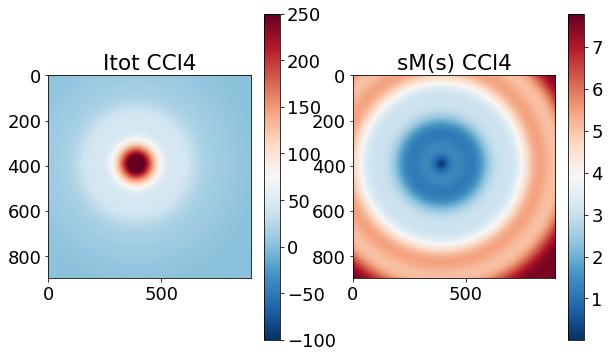

In [29]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(I_tot_ccl4, cmap = 'RdBu_r', vmin=-100, vmax=250)
plt.title('Itot CCl4')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sMs_ccl4, cmap = 'RdBu_r')
plt.title('sM(s) CCl4')
plt.colorbar()

#plt.imsave(fname='Itot_ccl4_simulated_kirk.png', arr=I_tot_ccl4, cmap='RdBu_r', format='png',vmin=-100, vmax=250)
#plt.imsave(fname='Iatom_ccl4_simulated_kirk.png', arr=I_atom_ccl4, cmap='RdBu_r', format='png',vmin=-100, vmax=250)
#plt.imsave(fname='Imol_ccl4_simulated_kirk.png', arr=I_mol_ccl4, cmap='RdBu_r', format='png',vmin=-100, vmax=250)

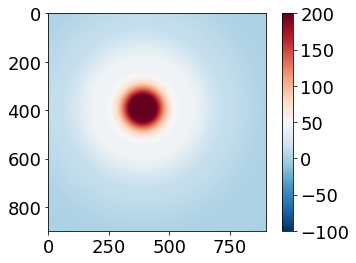

In [30]:
plt.imshow(I_tot_ccl4, cmap = 'RdBu_r', vmin=-100, vmax=200)
plt.colorbar()
plt.savefig('Itot_ccl4_simulated_kirk.png', bbox_inches = 'tight')

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


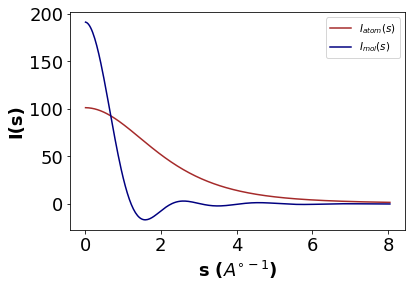

In [31]:
from diffraction_subfunctions import diffraction_to_azimuthal_avg

s_ccl4,I_mol_ccl4_1d = diffraction_to_azimuthal_avg(I_mol_ccl4)
_,I_bg_ccl4_1d = diffraction_to_azimuthal_avg(I_atom_ccl4)

sMs_Itot_Ibg_ccl4 = np.multiply(s_ccl4, np.divide(I_mol_ccl4_1d, I_bg_ccl4_1d))

plt.plot(s_ccl4, I_bg_ccl4_1d, label = '$I_{atom}(s)$', color = 'brown')
plt.plot(s_ccl4, I_mol_ccl4_1d, label = '$I_{mol}(s)$', color = 'navy')
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('I(s)')
plt.legend(fontsize = 'xx-small', loc=1)
plt.savefig('Iatom_and_Imol_ccl4.png', bbox_inches = 'tight')

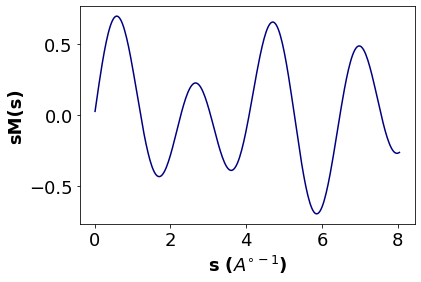

In [32]:
plt.plot(s_ccl4, sMs_Itot_Ibg_ccl4, color = 'navy')
plt.xlabel('s ($A^{\circ-1}$)')
plt.ylabel('sM(s)')
plt.savefig('sM(s)_ccl4.png', bbox_inches = 'tight')

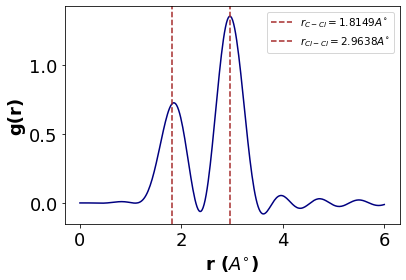

In [33]:
from diffraction_subfunctions import sms_to_mrdf

r_ccl4, mrdf_ccl4_v2 = sms_to_mrdf(s_ccl4, sMs_Itot_Ibg_ccl4)

plt.plot(r_ccl4,mrdf_ccl4_v2,color = 'navy')
plt.axvline(1.8149, ls = '--', color = 'brown', label = '$r_{C-Cl}=1.8149 A^{\circ}$')
plt.axvline(2.9638, ls = '--', color = 'brown', label = '$r_{Cl-Cl}=2.9638 A^{\circ}$')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)
plt.savefig('epdf_ccl4.png', bbox_inches = 'tight')

# Simulation for CO2 to further bench mark the code

In [34]:
#file from https://cccbdb.nist.gov/
#B3LYP/aug-cc-pVDZ
xyz_file_name ='co2.xyz'
xyz_co2 = pd.read_csv(os.path.join(xyz_file_path,xyz_file_name), sep = '\s+', dtype='str',names = ['Atoms', 'x', 'y', 'z'])
xyz_co2.iloc[0,0]
xyz_co2[["x", "y", "z"]] = xyz_co2[["x", "y", "z"]].apply(pd.to_numeric)
print(xyz_co2)
find_z(xyz_co2)
N_atoms = len(xyz_co2); print('Number of atoms in the molecule = {}'.format(N_atoms))
pairs = int(N_atoms*(N_atoms-1)/2); print('Number of pairs of atomic connections in the molecule = {}'.format(pairs));

  Atoms    x    y       z
0     C  0.0  0.0  0.0000
1     O  0.0  0.0  1.1674
2     O  0.0  0.0 -1.1674
Number of atoms in the molecule = 3
Number of pairs of atomic connections in the molecule = 3


In [35]:
%%time
I_atom_co2, I_mol_co2 = scattering_int(xyz_co2, dim = [899,899], s=s,N_atoms=len(xyz_co2), kirkland=kirkland_scat_fact);

I_tot_co2 = I_atom_co2+I_mol_co2

sMs_co2 = np.multiply(np.divide(I_tot_co2,I_atom_co2),s)

Wall time: 475 ms


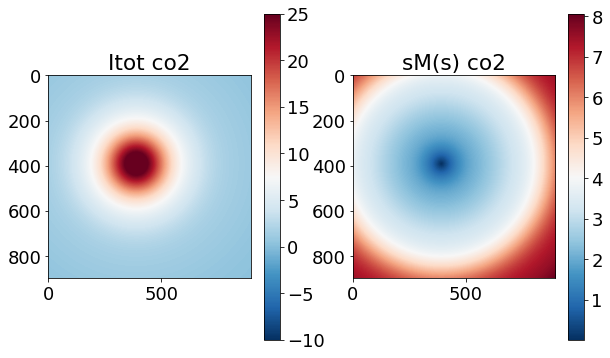

In [36]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(I_tot_co2, cmap = 'RdBu_r', vmin = -10, vmax = 25)
plt.title('Itot co2')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sMs_co2, cmap = 'RdBu_r')
plt.title('sM(s) co2')
plt.colorbar()

plt.imsave(fname='Itot_co2_simulated_kirk.png', arr=I_tot_co2, cmap='RdBu_r', format='png',vmin=-10, vmax=25)
plt.imsave(fname='Iatom_co2_simulated_kirk.png', arr=I_atom_co2, cmap='RdBu_r', format='png',vmin=-10, vmax=25)
plt.imsave(fname='Imol_co2_simulated_kirk.png', arr=I_mol_co2, cmap='RdBu_r', format='png',vmin=-10, vmax=25)

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


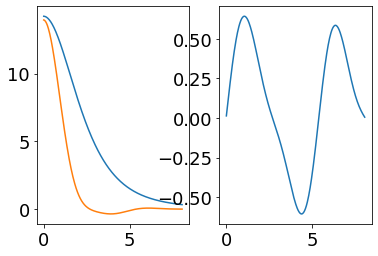

In [37]:
s_co2,I_mol_co2_1d = diffraction_to_azimuthal_avg(I_mol_co2)
_,I_bg_co2_1d = diffraction_to_azimuthal_avg(I_atom_co2)

sMs_Itot_Ibg_co2 = np.multiply(s_co2, np.divide(I_mol_co2_1d, I_bg_co2_1d))

plt.subplot(1,2,1)
plt.plot(s_co2, I_bg_co2_1d)
plt.plot(s_co2, I_mol_co2_1d)
plt.subplot(1,2,2)
plt.plot(s_co2, sMs_Itot_Ibg_co2)


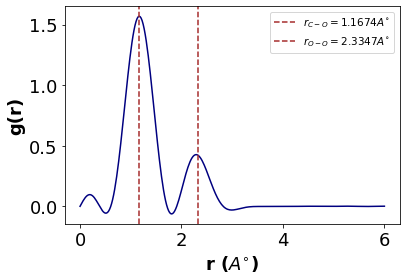

In [38]:
r_co2, mrdf_co2_v2 = sms_to_mrdf(s_co2, sMs_Itot_Ibg_co2)

plt.plot(r_co2,mrdf_co2_v2,color = 'navy')
plt.axvline(1.1674, ls = '--', color = 'brown', label = '$r_{C-O}=1.1674 A^{\circ}$')
plt.axvline(2.3347, ls = '--', color = 'brown', label = '$r_{O-O}=2.3347 A^{\circ}$')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)
plt.savefig('epdf_co2.png', bbox_inches = 'tight')

## Geometry file for Isolated glycerol

In [39]:
#reading the .xyz file for the corresponding molecule into a dataframe
#BLYP/aug-cc-pVDZ
xyz_file_path = os.getcwd()
xyz_file_name ='Glycerol.xyz'
xyz = pd.read_csv(os.path.join(xyz_file_path,xyz_file_name), sep = '\s+', dtype='str',names = ['Atoms', 'x', 'y', 'z'])
xyz.iloc[0,0]
xyz[["x", "y", "z"]] = xyz[["x", "y", "z"]].apply(pd.to_numeric)
print(len(xyz))
print(xyz)
find_z(xyz)
N_atoms = len(xyz); print('Number of atoms in the molecule = {}'.format(N_atoms))
pairs = int(N_atoms*(N_atoms-1)/2); print('Number of pairs of atomic connections in the molecule = {}'.format(pairs)); 
#r = np.zeros(pairs)

14
   Atoms       x       y       z
0      H -1.6410 -0.5055  1.4316
1      H -0.2327 -1.5528  0.9772
2      C -0.8731 -0.7078  0.6588
3      H  0.3665  0.8664  1.4467
4      C -0.0163  0.5500  0.4581
5      H  1.7016  1.3010 -0.6194
6      H  0.8412 -0.0444 -1.4635
7      C  1.1888  0.3291 -0.4794
8      H  2.8246 -0.7988 -0.4295
9      O  2.0673 -0.6364  0.1606
10     H -2.1564 -1.7093 -0.4941
11     O -1.5098 -0.9934 -0.6218
12     H -1.4055  1.2723 -0.7206
13     O -0.8194  1.6478 -0.0329
Number of atoms in the molecule = 14
Number of pairs of atomic connections in the molecule = 91


## Simulation  of electron diffraction pattern - Glycerol

In [40]:
%%time
#kirkland
Iatom_kirk, Imol_kirk = scattering_int(xyz, dim = [899,899],s=s, N_atoms=len(xyz), kirkland=kirkland_scat_fact);

#lobato
#Iatom_loba, Imol_loba = scattering_int_lobato(xyz=xyz, dim = [899,899], s=s, N_atoms=14);

Wall time: 7.22 s


In [41]:
Itot_kirk = Imol_kirk + Iatom_kirk
#Itot_loba = Imol_loba + Iatom_loba

sMs_gly_kirk = np.multiply(np.divide(Itot_kirk,Iatom_kirk),s)

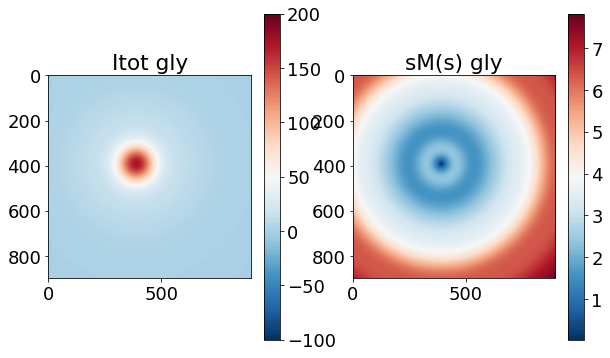

In [42]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(Itot_kirk, cmap = 'RdBu_r' , vmin = -100, vmax = 200)
plt.title('Itot gly')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sMs_gly_kirk, cmap = 'RdBu_r')
plt.title('sM(s) gly')
plt.colorbar()

plt.imsave(fname='Itot_gly_simulated_kirk.png', arr=Itot_kirk, cmap='RdBu_r', format='png',vmin=-100, vmax=200)
plt.imsave(fname='Iatom_gly_simulated_kirk.png', arr=Iatom_kirk, cmap='RdBu_r', format='png',vmin=-100, vmax=200)
plt.imsave(fname='Imol_gly_simulated_kirk.png', arr=Imol_kirk, cmap='RdBu_r', format='png',vmin=-100, vmax=200)

In [43]:
s_gly_kirk,I_mol_gly_kirk_1d = diffraction_to_azimuthal_avg(Imol_kirk)
_,I_atom_gly_kirk_1d = diffraction_to_azimuthal_avg(Iatom_kirk)

sMs_Itot_Ibg_gly_kirk = np.multiply(s_gly_kirk, np.divide(I_mol_gly_kirk_1d, I_atom_gly_kirk_1d))

Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg
Electron beam wavelength = 5.3553082697833555e-12 m
Detector Detector	 Spline= None	 PixelSize= 4.800e-05, 4.800e-05 m
Wavelength= 5.355308e-12m
SampleDetDist= 5.000000e-01m	PONI= 1.886544e-02, 1.879440e-02m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 500.000mm	Center: x=391.550, y=393.030 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg


(0.7, 8.0)

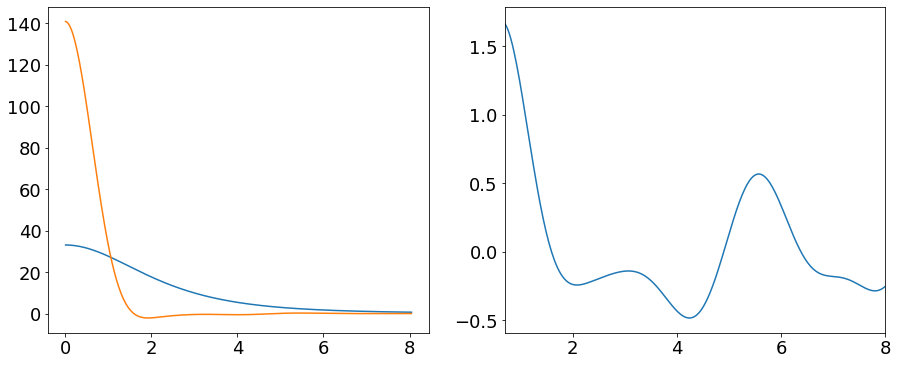

In [44]:
plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(s_gly_kirk, I_atom_gly_kirk_1d)
plt.plot(s_gly_kirk, I_mol_gly_kirk_1d)
plt.subplot(1,2,2)
plt.plot(s_gly_kirk, sMs_Itot_Ibg_gly_kirk)
plt.xlim([0.7,8])

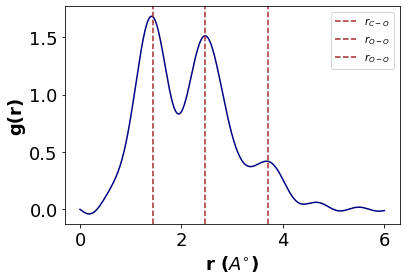

In [45]:
r_gly_kirk, mrdf_gly_kirk = sms_to_mrdf(s_gly_kirk, sMs_Itot_Ibg_gly_kirk)

plt.plot(r_gly_kirk,mrdf_gly_kirk,color = 'navy')
#plt.axvline(1.108, ls = '--', color = 'brown', label = '$r_{C-O}=1.1674 A^{\circ}$')
plt.axvline(1.43, ls = '--', color = 'brown', label = '$r_{C-O}$')
plt.axvline(2.47, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.axvline(3.7, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)

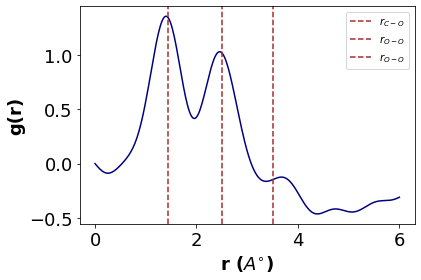

In [46]:
def cut_array(sx,Itot):
    s_cut = []
    I_cut = []
    for s,I in zip(sx,Itot):
        if s>=0.6 and s<=8.0:
            s_cut.append(s)
            I_cut.append(I)
        else:
            continue
    return s_cut, I_cut

s_cut, sMs_cut = cut_array(s_gly_kirk, sMs_Itot_Ibg_gly_kirk)

r_cut, mrdf_cut = sms_to_mrdf(s_cut, sMs_cut)

plt.plot(r_cut, mrdf_cut,color = 'navy')
#plt.axvline(1.108, ls = '--', color = 'brown', label = '$r_{C-O}=1.1674 A^{\circ}$')
plt.axvline(1.43, ls = '--', color = 'brown', label = '$r_{C-O}$')
plt.axvline(2.5, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.axvline(3.5, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)

# Liquid glycerol simulation

In [47]:
#fname_liq = 'liquid_glycerol_398molecules_298k.xyz'
fname_liq = 'liquid_glycerol_sim.xyz'
folder_name = os.path.join(os.getcwd(),'Geometry_files')
liq_file = os.path.join(folder_name,fname_liq)
print(liq_file)
xyz_liq = pd.read_csv(liq_file, sep = '\s+', dtype='str',names = ['Atoms', 'x', 'y', 'z'])
xyz_liq.iloc[0,0]
xyz_liq[["x", "y", "z"]] = xyz_liq[["x", "y", "z"]].apply(pd.to_numeric)
print(len(xyz_liq))
print(xyz_liq)
find_z(xyz_liq)
N_atoms = len(xyz_liq); print('Number of atoms in the molecule = {}'.format(N_atoms))
pairs = int(N_atoms*(N_atoms-1)/2); print('Number of pairs of atomic connections in the molecule = {}'.format(pairs)); 

H:\My Documents\GitHub\Electron-diffraction\Geometry_files\liquid_glycerol_sim.xyz
1177
     Atoms         x         y         z
0        C   8.24722   9.03547  13.48289
1        C  -1.51289   9.22888  17.00780
2        C   9.45147  16.07948  15.03773
3        C  10.52460  11.04864   8.57367
4        C   0.25945   0.98311  17.35075
...    ...       ...       ...       ...
1172     O   5.02854   9.45537  18.69637
1173     O  17.64137  23.89747   4.95700
1174     O   6.11418  22.01551  14.51745
1175     O  20.02406   9.47026   9.41836
1176     O   1.68530  13.48281   3.25808

[1177 rows x 4 columns]
Number of atoms in the molecule = 1177
Number of pairs of atomic connections in the molecule = 692076


In [48]:
%%time
#kirkland
#Iatom_kirk_liq, Imol_kirk_liq = scattering_int(xyz_liq, dim = [899,899],s=s, N_atoms=len(xyz_liq), kirkland=kirkland_scat_fact)

Wall time: 0 ns


Itot_kirk_liq = Imol_kirk_liq + Iatom_kirk_liq
#Itot_loba = Imol_loba + Iatom_loba

sMs_gly_kirk_liq = np.multiply(np.divide(Itot_kirk_liq,Iatom_kirk_liq),s)

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(Itot_kirk_liq, cmap = 'gray' , vmin = 80, vmax = 5000)
plt.title('Itot gly')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(sMs_gly_kirk_liq, cmap = 'RdBu_r')
plt.title('sM(s) gly')
plt.colorbar()

plt.imsave(fname='Itot_gly_simulated_kirk_liq.png', arr=Itot_kirk_liq, cmap='RdBu_r', format='png',vmin=-100, vmax=200)
plt.imsave(fname='Iatom_gly_simulated_kirk_liq.png', arr=Iatom_kirk_liq, cmap='RdBu_r', format='png',vmin=-100, vmax=200)
plt.imsave(fname='Imol_gly_simulated_kirk_liq.png', arr=Imol_kirk_liq, cmap='RdBu_r', format='png',vmin=-100, vmax=200)

s_gly_kirk_liq,I_mol_gly_kirk_liq_1d = diffraction_to_epdf(Imol_kirk_liq)
_,I_atom_gly_kirk_liq_1d = diffraction_to_epdf(Iatom_kirk_liq)

sMs_Itot_Ibg_gly_kirk_liq = np.multiply(s_gly_kirk_liq, np.divide(I_mol_gly_kirk_liq_1d, I_atom_gly_kirk_liq_1d))

plt.figure(figsize=(15, 6))
plt.subplot(1,2,1)
plt.plot(s_gly_kirk_liq, I_atom_gly_kirk_liq_1d)
plt.plot(s_gly_kirk_liq, I_mol_gly_kirk_liq_1d)
plt.subplot(1,2,2)
plt.plot(s_gly_kirk_liq, sMs_Itot_Ibg_gly_kirk_liq)
plt.xlim([1,8])
plt.ylim([-5,5])

mrdf_gly_kirk_liq = sms_to_mrdf(s_gly_kirk_liq, sMs_Itot_Ibg_gly_kirk_liq)

plt.plot(s_gly_kirk_liq,mrdf_gly_kirk_liq,color = 'navy')
#plt.axvline(1.108, ls = '--', color = 'brown', label = '$r_{C-O}=1.1674 A^{\circ}$')
plt.axvline(1.43, ls = '--', color = 'brown', label = '$r_{C-O}$')
plt.axvline(2.47, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.axvline(3.7, ls = '--', color = 'brown', label = '$r_{O-O}$')
plt.xlabel('r ($A^{\circ}$)')
plt.ylabel('g(r)')
plt.legend(fontsize = 'xx-small', loc=1)
plt.savefig('liquid_epdf_1177_atoms.png', bbox_inches='tight')